In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('mandelbrot_benchmark_results.csv')

print(df.shape)
print("\n DataSet Columns:")
print(df.columns.tolist())

df.head()

(256, 6)

 DataSet Columns:
['Iterations', 'SchedulingPolicy', 'Threads', 'ChunkSize', 'ChunkMethod', 'TimeTaken']


,Iterations,SchedulingPolicy,Threads,ChunkSize,ChunkMethod,TimeTaken
0,1000,Static-block,1,1,by Row,0.805
1,1000,Static-block,1,1,by Column,0.730
2,1000,Static-block,1,50,by Row,0.725
3,1000,Static-block,1,50,by Column,0.731
4,1000,Static-block,1,100,by Row,0.730


Analyzing Thread Scaling by Iteration Count

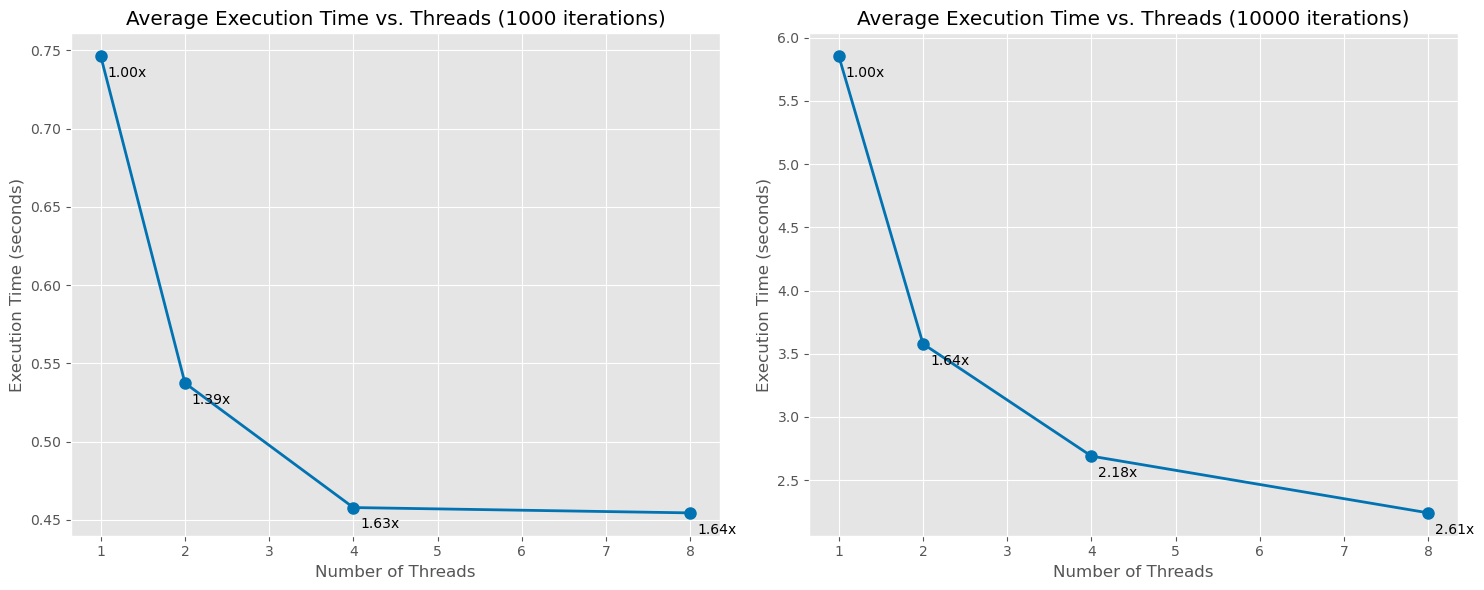

In [19]:
plt.style.use('ggplot')
sns.set_palette("colorblind")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, iteration in enumerate([1000, 10000]):
    ax = axes[i]
    
    iter_df = df[df['Iterations'] == iteration]
    thread_perf = iter_df.groupby('Threads')['TimeTaken'].mean().reset_index()
    
    ax.plot(thread_perf['Threads'], thread_perf['TimeTaken'], 'o-', linewidth=2, markersize=8)
    ax.set_title(f'Average Execution Time vs. Threads ({iteration} iterations)')
    ax.set_xlabel('Number of Threads')
    ax.set_ylabel('Execution Time (seconds)')
    ax.grid(True)


    serial_time = thread_perf[thread_perf['Threads'] == 1]['TimeTaken'].values[0]
    for threads, time in zip(thread_perf['Threads'], thread_perf['TimeTaken']):
        speedup = serial_time / time
        ax.annotate(f'{speedup:.2f}x', 
                   xy=(threads, time), 
                   xytext=(5, -15),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

Comparing Scheduling Policies

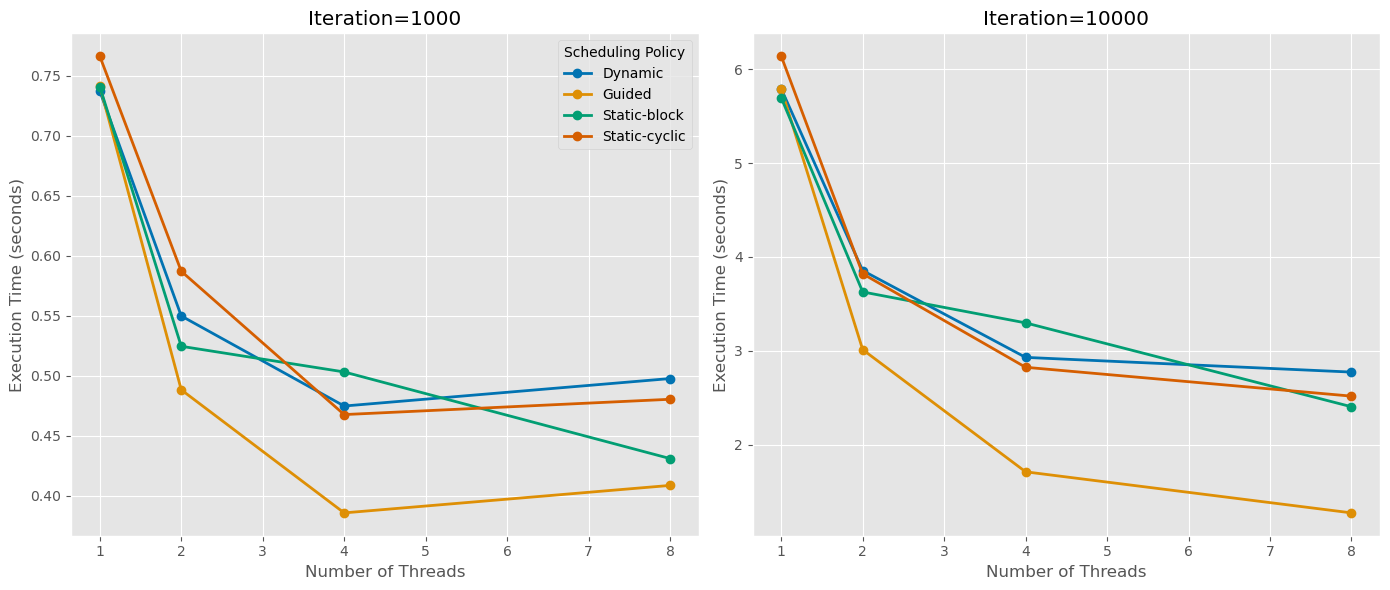

In [20]:
plt.figure(figsize=(14, 6))

for iter_idx, iteration in enumerate([1000, 10000]):
    iter_df = df[df['Iterations'] == iteration]
    
    plt.subplot(1, 2, iter_idx + 1)
    
    for policy in sorted(df['SchedulingPolicy'].unique()):
        policy_df = iter_df[iter_df['SchedulingPolicy'] == policy]
        
        thread_perf = policy_df.groupby('Threads')['TimeTaken'].mean()
        
        plt.plot(thread_perf.index, thread_perf.values, 'o-', linewidth=2, label=policy)
    
    plt.title(f'Iteration={iteration}')
    plt.xlabel('Number of Threads')
    plt.ylabel('Execution Time (seconds)')
    plt.grid(True)
    if iter_idx == 0:
        plt.legend(title='Scheduling Policy')

plt.tight_layout()
plt.show()

Calculating Speedup and Efficiency

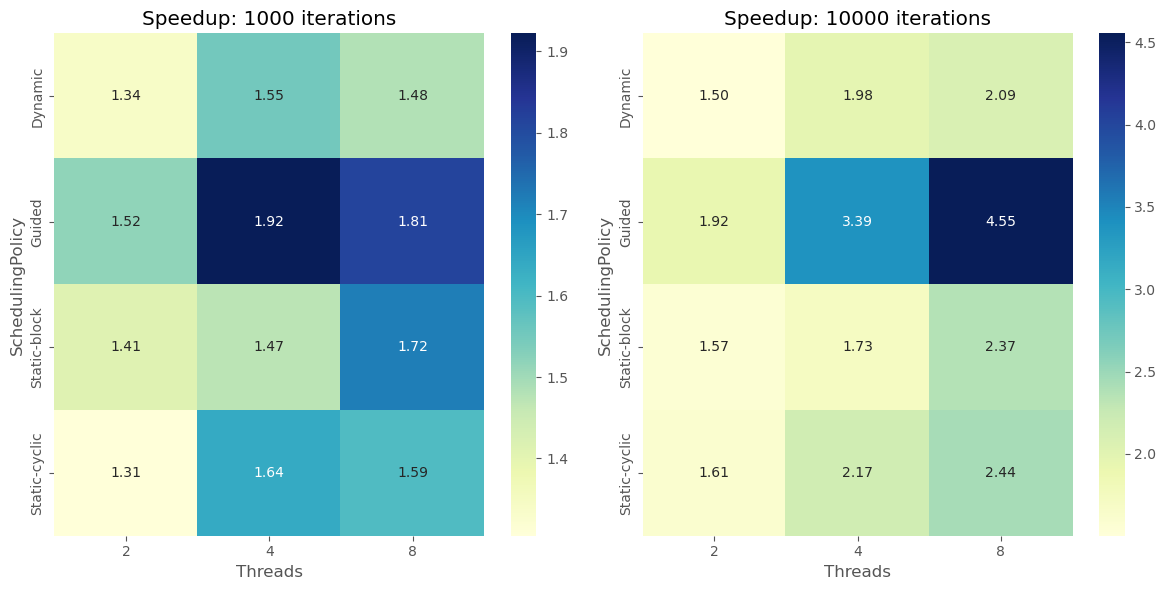

In [21]:
results = []

for iteration in sorted(df['Iterations'].unique()):
    for policy in sorted(df['SchedulingPolicy'].unique()):
        baseline = df[(df['Iterations'] == iteration) & 
                      (df['SchedulingPolicy'] == policy) & 
                      (df['Threads'] == 1)]['TimeTaken'].mean()
        
        for thread in [1, 2, 4, 8]:
            avg_time = df[(df['Iterations'] == iteration) & 
                         (df['SchedulingPolicy'] == policy) & 
                         (df['Threads'] == thread)]['TimeTaken'].mean()
            
            speedup = baseline / avg_time
            efficiency = speedup / thread
            
            results.append({
                'Iterations': iteration,
                'SchedulingPolicy': policy,
                'Threads': thread,
                'AvgTime': avg_time,
                'Speedup': speedup,
                'Efficiency': efficiency
            })

metrics_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
for i, iteration in enumerate([1000, 10000]):
    plt.subplot(1, 2, i + 1)
    
    data = metrics_df[(metrics_df['Iterations'] == iteration) & 
                      (metrics_df['Threads'] > 1)]
    
    pivot = data.pivot_table(index='SchedulingPolicy', 
                            columns='Threads', 
                            values='Speedup')
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title(f'Speedup: {iteration} iterations')

plt.tight_layout()
plt.show()

Best Configurations

In [22]:
best_configs = df.groupby(['Iterations', 'SchedulingPolicy', 'Threads', 'ChunkMethod', 'ChunkSize'])['TimeTaken'].mean().reset_index()
best_configs = best_configs.sort_values(['Iterations', 'TimeTaken'])

for iteration in [1000, 10000]:
    iteration_results = best_configs[best_configs['Iterations'] == iteration].head(5)
    print(f"\nTop 5 fastest configurations for {iteration} iterations:")
    print(iteration_results[['SchedulingPolicy', 'Threads', 'ChunkMethod', 'ChunkSize', 'TimeTaken']])

overall_speedup = df.groupby(['Iterations', 'Threads'])['TimeTaken'].mean().reset_index()
overall_speedup = overall_speedup.pivot(index='Iterations', columns='Threads', values='TimeTaken')
overall_speedup['Speedup_8_threads'] = overall_speedup[1] / overall_speedup[8]

print("\nOverall speedup from 1 to 8 threads:")
print(overall_speedup['Speedup_8_threads'])


Top 5 fastest configurations for 1000 iterations:
    SchedulingPolicy  Threads ChunkMethod  ChunkSize  TimeTaken
21           Dynamic        4      by Row         50      0.356
52            Guided        4      by Row          1      0.367
113    Static-cyclic        4   by Column         50      0.371
55            Guided        4      by Row        720      0.375
118    Static-cyclic        4      by Row        100      0.375

Top 5 fastest configurations for 10000 iterations:
    SchedulingPolicy  Threads ChunkMethod  ChunkSize  TimeTaken
191           Guided        8      by Row        720      1.187
252    Static-cyclic        8      by Row          1      1.212
188           Guided        8      by Row          1      1.230
189           Guided        8      by Row         50      1.234
190           Guided        8      by Row        100      1.255

Overall speedup from 1 to 8 threads:
Iterations
1000     1.642390
10000    2.612989
Name: Speedup_8_threads, dtype: float64
